# Computer Lab 3 - ENGN4528 - 2021

**Name:** Thao Pham  
**Student ID:** u7205329  
**Date:** 22/05/2021

In [1]:
# import libraries

import numpy as np
import cv2 
import matplotlib.pyplot as plt

# Task 1: 3D-2D Camera Calibration

## Preparing inputs

In [2]:
uv = np.load('uv_coords.npy')

In [3]:
XYZ = np.array([[0,6,3],
                [3,6,0],
                [0,2,3],
                [1,1,0],
                [2,3,0],
                [0,5,1],
                [3,2,0],
                [0,4,2],
                [1,0,1],
                [1,0,3],
                [3,0,3],
                [3,0,1]]) * 7

List the calibrate function in your PDF file. [3 marks]

In [4]:
def calibrate(im, XYZ, uv):
    N = len(uv)
    A = np.zeros((2*N, 12))
    
    # Compute Ai for each correspondence and assemble matrix A
    n = 0
    for i in range(N):
        Xi, Yi, Zi = XYZ[i]
        ui, vi = uv[i]
        Ai = np.array([[0, 0, 0, 0, -Xi, -Yi, -Zi, -1, vi*Xi, vi*Yi, vi*Zi, vi],
                       [Xi, Yi, Zi, 1, 0, 0, 0, 0, -ui*Xi, -ui*Yi, -ui*Zi, -ui]])
        A[n:n+2,:] = Ai
        n += 2

    # SVD and normalisation
    U,D,V = np.linalg.svd(A)
    p = V[-1]
    p = p/np.linalg.norm(p)
    
    C = np.reshape(p,(3,4))
    
    # Get projected points using the calibration matrix C
    XYZ_homogenous = np.column_stack((XYZ, np.ones(N)))
    projected_points = np.zeros(uv.shape)
    squared_error = []

    for i in range(N):
        x_hat = C@XYZ_homogenous[i] # projected point in homogenous coords
        x_hat = x_hat/x_hat[-1] # convert projected point to Cartesian coords
        projected_points[i] = x_hat[:2]
        err = x_hat[:2] - uv[i] 
        squared_error.append(err*err) # add squared error 
        
    # Overlay the the world coordinate system
    wcs = np.array([[0,0,0], [0,0,1], [0,1,0], [1,0,0]])*7
    wcs_homogenous = np.column_stack((wcs,np.ones(len(wcs))))

    image_cs = []
    for i in range(len(wcs_homogenous)):
        x_hat = C@wcs_homogenous[i]
        x_hat = x_hat/x_hat[-1]
        image_cs.append(x_hat[:2])

    # Report the error 
    print('Mean squared error between uv and projected points: {}'.format(np.mean(squared_error)))
    
    
    # Plot the image with uv coords as well as projected points
    fig,axs = plt.subplots(figsize = (9,6.923))
    axs.imshow(im)
    axs.scatter(projected_points[:,0], projected_points[:,1], marker = 'o', color = 'yellow', s = 30, label = 'Projected')
    axs.scatter(uv[:,0], uv[:,1], marker = 'x', color = 'red', s = 30, label = 'uv')
    
    # Overlay the world coordinate system
    coords = ('z', 'y', 'x')
    for i in range(1,len(image_cs)):
        axs.arrow(image_cs[0][0], image_cs[0][1], 
                 image_cs[i][0] - image_cs[0][0], 
                  image_cs[i][1] - image_cs[0][1], head_width = 10, color = 'k')
        axs.text(image_cs[i][0]+10, image_cs[i][1]+10, coords[i-1], c = 'white', fontsize = 15)
    axs.legend()
    axs.axis('off')
    plt.show()
    
    return C

List the 3x4 camera calibration matrix P that you have calculated for the
selected image. Please visualise the projection of the XYZ coordinates back
onto image using the calibration matrix P. [2 marks]

Mean squared error between uv and projected points: 0.1345243974790037


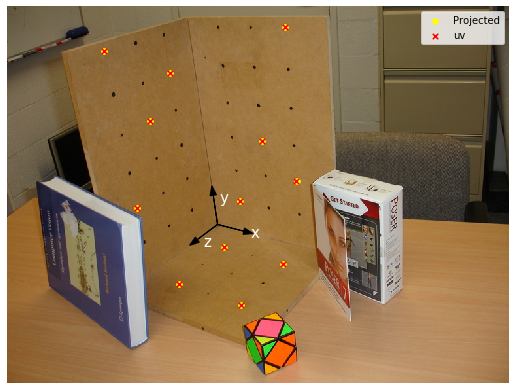

In [5]:
I = cv2.imread('stereo2012a.jpg', 1)
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
C = calibrate(I, XYZ, uv)

In [6]:
print(C)

[[ 8.93387541e-03 -4.28501327e-03 -1.32964565e-02  6.94166414e-01]
 [-1.04508048e-04 -1.58422754e-02  2.54442448e-03  7.19441374e-01]
 [-9.58216349e-06 -7.22470683e-06 -1.29438062e-05  2.15972720e-03]]


Decompose the P matrix into K, R, t, such that P = K[R|t], by using the following provided code (vgg_KR_from_P.m or vgg_KR_from_P.py). List the results, namely the K, R, t matrices, in your PDF file. [1.5 marks]

In [7]:
# -*- coding: utf-8 -*-
'''
%VGG_KR_FROM_P Extract K, R from camera matrix.
%
%    [K,R,t] = VGG_KR_FROM_P(P [,noscale]) finds K, R, t such that P = K*R*[eye(3) -t].
%    It is det(R)==1.
%    K is scaled so that K(3,3)==1 and K(1,1)>0. Optional parameter noscale prevents this.
%
%    Works also generally for any P of size N-by-(N+1).
%    Works also for P of size N-by-N, then t is not computed.

% original Author: Andrew Fitzgibbon <awf@robots.ox.ac.uk> and awf
% Date: 15 May 98

% Modified by Shu, ANU.
% Date: 8 May 20
'''
import numpy as np

def vgg_rq(S):
    S = S.T
    [Q,U] = np.linalg.qr(S[::-1,::-1], mode='complete')

    Q = Q.T
    Q = Q[::-1, ::-1]
    U = U.T
    U = U[::-1, ::-1]
    if np.linalg.det(Q)<0:
        U[:,0] = -U[:,0]
        Q[0,:] = -Q[0,:]
    return U,Q


def vgg_KR_from_P(P, noscale = True):
    N = P.shape[0]
    H = P[:,0:N]
    print(N,'|', H)
    [K,R] = vgg_rq(H)
    if noscale:
        K = K / K[N-1,N-1]
        if K[0,0] < 0:
            D = np.diag([-1, -1, np.ones([1,N-2])]);
            K = K @ D
            R = D @ R
        
            test = K*R; 
            assert (test/test[0,0] - H/H[0,0]).all() <= 1e-07
    
    t = np.linalg.inv(-P[:,0:N]) @ P[:,-1]
    return K, R, t

In [8]:
K, R, t = vgg_KR_from_P(C)

3 | [[ 8.93387541e-03 -4.28501327e-03 -1.32964565e-02]
 [-1.04508048e-04 -1.58422754e-02  2.54442448e-03]
 [-9.58216349e-06 -7.22470683e-06 -1.29438062e-05]]


In [9]:
print(K)
print()
print(R)
print()
print(t)

[[860.45566575   7.40872827 377.00679019]
 [  0.         869.60833087 264.8723659 ]
 [  0.           0.           1.        ]]

[[ 0.82471637 -0.09498259 -0.55751343]
 [ 0.15854293 -0.90743814  0.38912744]
 [-0.54286928 -0.40930959 -0.73332027]]

[71.48961024 58.03684087 81.53729202]


Please resize your selected image using built-in functions from matlab or python to (H/2, W/2) where H, and W denote the original size of your selected image. 

Using the interface function, (ginput in Matlab, and matplotlib.pyplot.ginput in Python) to find the uv coordinates in the resized image.

In [10]:
h,w = I.shape[:2]
uv2 = np.load('uv_resized_coords.npy')

I_resized = cv2.resize(I, (w//2,h//2))

Mean squared error between uv and projected points: 0.026956198004420524


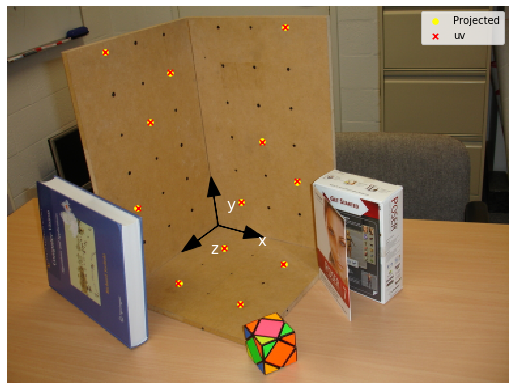

In [11]:
C_ = calibrate(I_resized, XYZ, uv2)

List your calculated 3x4 camera calibration matrix P’ and the decomposed K’, R’, t’ in your PDF file.

In [12]:
print(C_)

[[ 9.04242532e-03 -4.23977582e-03 -1.31279191e-02  6.93543378e-01]
 [-3.78358528e-05 -1.58932468e-02  2.80046489e-03  7.20032288e-01]
 [-1.86441981e-05 -1.40328552e-05 -2.35566448e-05  4.30864468e-03]]


In [13]:
K_, R_, t_ = vgg_KR_from_P(C_)

3 | [[ 9.04242532e-03 -4.23977582e-03 -1.31279191e-02]
 [-3.78358528e-05 -1.58932468e-02  2.80046489e-03]
 [-1.86441981e-05 -1.40328552e-05 -2.35566448e-05]]


In [14]:
K, K_

(array([[860.45566575,   7.40872827, 377.00679019],
        [  0.        , 869.60833087, 264.8723659 ],
        [  0.        ,   0.        ,   1.        ]]),
 array([[462.94848263,   3.04318019, 182.05325862],
        [  0.        , 465.07257647, 143.49406169],
        [  0.        ,   0.        ,   1.        ]]))

In [15]:
R, R_

(array([[ 0.82471637, -0.09498259, -0.55751343],
        [ 0.15854293, -0.90743814,  0.38912744],
        [-0.54286928, -0.40930959, -0.73332027]]),
 array([[ 0.80906199, -0.10385599, -0.5784744 ],
        [ 0.17103491, -0.90005782,  0.40080293],
        [-0.56228619, -0.42321373, -0.71043957]]))

In [16]:
t, t_

(array([71.48961024, 58.03684087, 81.53729202]),
 array([76.76065149, 60.31442019, 86.2228205 ]))

# Task 2: Two-View DLT based homography estimation. 

In [19]:
def prepare_data(left_file, right_file):
    left = np.load(left_file)
    right = np.load(right_file)
    uBase, vBase = left[:,0], left[:,1]
    u2Trans, v2Trans = right[:,0], right[:,1]
    return left, right, u2Trans, v2Trans, uBase, vBase

In [20]:
left, right, u2Trans, v2Trans, uBase, vBase = prepare_data('uv_left.npy', 'uv_right.npy')

List your source code for the homography estimation function and display the two images and the location of six pairs of selected points (namely, plotted those points on images). **[5 marks]**

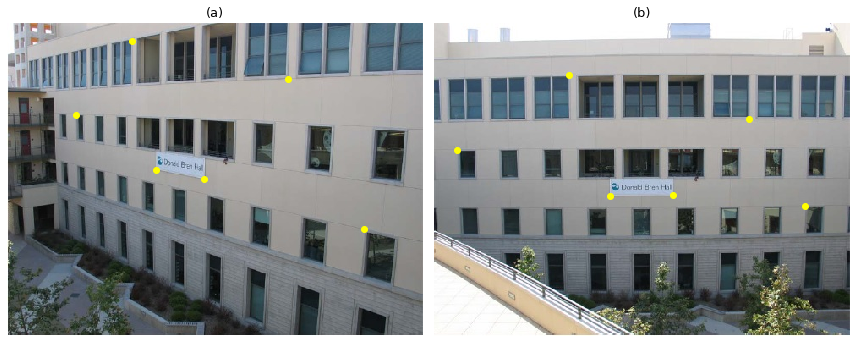

In [24]:
left_img = cv2.imread('Left.jpg', 1)
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)

right_img = cv2.imread('Right.jpg', 1)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1,2, figsize = (12, 6))
axs[0].imshow(left_img)
axs[0].scatter(left[:,0], left[:,1], c = 'yellow')
axs[0].set_title('(a)', fontsize = 13)
axs[1].imshow(right_img)
axs[1].scatter(right[:,0], right[:,1], c = 'yellow')
axs[1].set_title('(b)', fontsize = 13)
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.savefig('Task2.png')
plt.show()


In [21]:
def homography(u2Trans, v2Trans, uBase, vBase):
    N = len(uBase)
    A = np.zeros((2*N, 9))
    
    # Calculate Ai for each correspondence and assemble A
    n = 0
    for i in range(N):
        xi, yi = uBase[i], vBase[i]
        xi_, yi_ = u2Trans[i], v2Trans[i]
        Ai = np.array([[0, 0, 0, -xi, -yi, -1, yi_*xi, yi_*yi, yi_],
                       [xi, yi, 1, 0, 0, 0, -xi_*xi, -xi_*yi, -xi_]])
        A[n:n+2,:] = Ai
        n += 2
        
    # SVD and normalisation
    U,D,V = np.linalg.svd(A)
    h = V[-1]
    h = h/np.linalg.norm(h)
    
    H = np.reshape(h,(3,3))
    return H

List the 3x3 camera homography matrix H that you have calculated. [2 marks]

In [28]:
H = homography(u2Trans, v2Trans, uBase, vBase)
print(H)

[[ 1.42056426e-02 -4.20179144e-05 -9.99142030e-01]
 [ 2.23954006e-03  6.36855850e-03 -3.80737848e-02]
 [ 1.73865674e-05 -1.03505527e-06  4.26793023e-03]]


Warp the left image according to the calculated homography. Study the factors that affect the rectified results, e.g., the distance between the corresponding points, the selected points and the warped ones. **[3 marks]**

In [26]:
# Perform perspective transformation

h,w,c = left_img.shape
H_transformed = cv2.warpPerspective(left_img, H, (w,h))

In [25]:
# Warped points 

left_in_homogenous = np.column_stack((left, np.ones(len(left))))
warped = []

for point in left_in_homogenous:
    warped_x = H@point
    warped.append(warped_x/warped_x[-1])
    
warped = np.array(warped)
warped

array([[159.58268181,  62.1091706 ,   1.        ],
       [372.6222478 , 112.84047285,   1.        ],
       [ 27.16002625, 149.42242524,   1.        ],
       [208.29927717, 204.17869435,   1.        ],
       [283.08515992, 203.55167329,   1.        ],
       [438.91665307, 216.50234304,   1.        ]])

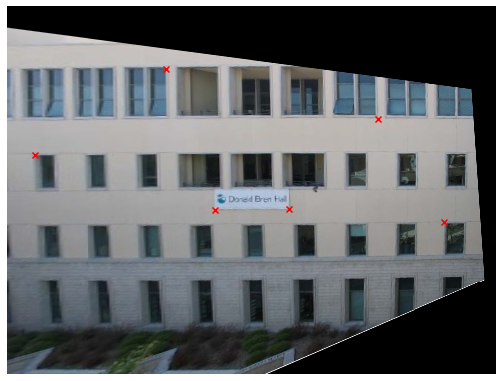

In [27]:
# Rectified image

H_transformed = H_transformed.reshape(left_img.shape)
fig, axs = plt.subplots(figsize = (9, 6.76))
plt.scatter(warped[:,0], warped[:,1], c = 'red', marker = 'x' )
plt.axis('off')
plt.imshow(H_transformed.astype('uint8'))
#plt.savefig('warped.png')
plt.show()